<a href="https://colab.research.google.com/github/snassimr/CommonLit/blob/master/CommonLit_V12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [39]:
%reload_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [40]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [41]:
SYS_PROJECT_DIR = '/content/gdrive/MyDrive/Colab Notebooks/CommonLit'
SYS_VERSION_DIR = '/content/gdrive/MyDrive/Colab Notebooks/CommonLit/V12'
SYS_OUTPUT_DIR  = '/content/gdrive/MyDrive/Colab Notebooks/CommonLit/V12'
SYS_LLM_DIR     = '/content/gdrive/MyDrive/Colab Notebooks/CommonLit/llm'

In [42]:
!pip install dill

In [43]:
import os
import pandas as pd
import shutil

In [44]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [45]:
# shutil.rmtree('test123')

In [46]:
# set random seed
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(seed=42)

# Explore environment

In [47]:
# import psutil
# import platform
# uname = platform.uname()
# print(f"System: {uname.system}")  #Windows or Linux
# print(f"Node Name: {uname.node}") # System name
# print(f"Release: {uname.release}") # OS release version like  10(Windows) or 5.4.0-72-generic(linux)
# print(f"Version: {uname.version}")
# print(f"Machine: {uname.machine}")  # machine can be AMD64 or x86-64
# print(f"Processor: {uname.processor}") #  Intel64 Family 6 or x86_64
# print("Physical cores:", psutil.cpu_count(logical=False))
# print("Total cores:", psutil.cpu_count(logical=True))

# def get_size(bytes, suffix="B"):
#     """
#     Scale bytes to its proper format- KB, MB, GB, TB and PB
#     """
#     factor = 1024
#     for unit in ["", "K", "M", "G", "T", "P"]:
#         if bytes < factor:
#             return f"{bytes:.2f}{unit}{suffix}"
#         bytes /= factor

# print("Virtual memory")
# svmem = psutil.virtual_memory()
# print(f"Total: {get_size(svmem.total)}")
# print(f"Available: {get_size(svmem.available)}")
# print(f"Used: {get_size(svmem.used)}")

# Read Data

In [48]:
commonlit_texts = pd.read_csv(os.path.join(SYS_PROJECT_DIR,'commonlit_texts.csv'))

def grade_to_text(grade):
    return "G" + str(grade)

commonlit_texts['grade'] = commonlit_texts['grade'].apply(grade_to_text)
commonlit_texts = commonlit_texts.drop_duplicates(subset='title', keep=False)

## Train Data

In [49]:
prompts_train   = pd.read_csv(os.path.join(SYS_PROJECT_DIR,'prompts_train.csv'))
summaries_train = pd.read_csv(os.path.join(SYS_PROJECT_DIR,'summaries_train.csv'))

In [50]:
print(f"Prompts train shape: {prompts_train.shape}")
display(prompts_train.head())
print(f"Summary train shape: {summaries_train.shape}")
display(summaries_train.head())

Prompts train shape: (4, 4)


,prompt_id,prompt_question,prompt_title,prompt_text
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
2,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."


Summary train shape: (7165, 5)


,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757


In [51]:
prompts_train = prompts_train.merge(commonlit_texts[['title', 'grade', 'genre']], how='left', left_on='prompt_title', right_on='title')
prompts_train['grade'] = prompts_train['grade'].fillna("G")
prompts_train['genre'] = prompts_train['genre'].fillna("Genre")

In [52]:
prompts_train

,prompt_id,prompt_question,prompt_title,prompt_text,title,grade,genre
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,On Tragedy,G9,Philosophy
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,Egyptian Social Structure,G7,Informational Text
2,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,The Third Wave,G9,Informational Text
3,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...",NaN,G,Genre


## Test Data

In [53]:
prompts_test   = pd.read_csv(os.path.join(SYS_PROJECT_DIR,'prompts_test.csv'))
summaries_test = pd.read_csv(os.path.join(SYS_PROJECT_DIR,'summaries_test.csv'))

In [54]:
print(f"Prompts test shape: {prompts_test.shape}")
display(prompts_test.head())
print(f"Summary test shape: {summaries_test.shape}")
display(summaries_test.head())

Prompts test shape: (2, 4)


,prompt_id,prompt_question,prompt_title,prompt_text
0,abc123,Summarize...,Example Title 1,Heading\nText...
1,def789,Summarize...,Example Title 2,Heading\nText...


Summary test shape: (4, 3)


,student_id,prompt_id,text
0,000000ffffff,abc123,Example text 1
1,111111eeeeee,def789,Example text 2
2,222222cccccc,abc123,Example text 3
3,333333dddddd,def789,Example text 4


In [55]:
prompts_test = prompts_test.merge(commonlit_texts[['title', 'grade', 'genre']], how='left', left_on='prompt_title', right_on='title')
prompts_test['grade'] = prompts_test['grade'].fillna("G")
prompts_test['genre'] = prompts_test['genre'].fillna("Genre")

In [56]:
prompts_test

,prompt_id,prompt_question,prompt_title,prompt_text,title,grade,genre
0,abc123,Summarize...,Example Title 1,Heading\nText...,NaN,G,Genre
1,def789,Summarize...,Example Title 2,Heading\nText...,NaN,G,Genre


# Model Config

## Initialize Model_Config

In [57]:
Model_Config = {
    'model_name' : 'debertav3large',
    'base_model' : {
      'root_dir'      : 'debertav3large',
      'model_name'    : 'debertav3large',
      'num_labels'    : 2,
      'problem_type'  : 'regression',
      'hidden_dropout_prob' : 0.007,
      'attention_probs_dropout_prob' : 0.007,
      'max_length' : 1024,
      'save_steps' : 100
    },
    'llm' : {
        'model_dir' : 'meta-llama_Llama-2-7b-chat-hf',
        'max_new_tokens' : 250
    },
    'input_text_col' : 'text',
    'input_text_cols' : ['grade', 'genre', 'prompt_title', 'prompt_question', 'text'],
    'model_root_dir': 'model',
    'random_seed' : 42,
    'n_splits'    : 4,
    'num_train_epochs' : 3,
    'learning_rate' : 1.5e-5,
    'train_batch_size' : 2,
    'eval_batch_size'  : 16,
    'gradient_accumulation_steps' : 8,
    'weight_decay'  : 0.02,
    'control' : {
        'freeze_layers' : True
    },
    'freeze_layers' : {
        'debertav3base'  : {
            'first' : 0, 'last' : 6
        },
        'debertav3large' : {
            'first' : 0, 'last' : 6
        }
    }
}

In [58]:
# Model_Config['XXX'] = ""

# Load Models

In [59]:
!pip install accelerate==0.20.3
!pip install transformers==4.30.2
!pip install datasets
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 103.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.2 MB/s eta 0:00:00


## Load LLM model

In [60]:
# import os
# bitsandbytes_path = os.path.join(SYS_PROJECT_DIR, "bitsandbytes-0.41.1-py3-none-any.whl")
# !pip install "{bitsandbytes_path}"

In [61]:
# import torch, accelerate
# from transformers import BitsAndBytesConfig
# from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig
# from datasets import Dataset

# import os
# llm_model_dir = Model_Config['llm']['model_dir']
# llm_model_local_dir = os.path.join(SYS_LLM_DIR, llm_model_dir)


# compute_dtype = getattr(torch, "float16")
# bnb_config = BitsAndBytesConfig(
#         load_in_4bit=True,
#         bnb_4bit_quant_type="nf4",
#         bnb_4bit_compute_dtype=compute_dtype,
#         bnb_4bit_use_double_quant=True,
# )

# n_gpus = torch.cuda.device_count()
# max_memory = f'{16384}MB'
# llm_model = AutoModelForCausalLM.from_pretrained(
#           llm_model_local_dir, quantization_config=bnb_config,
#           device_map={"": 0},
#           # device_map = "auto",  max_memory = {i: max_memory for i in range(n_gpus)}
#           )
# llm_model.config.use_cache = False
# llm_tokenizer = AutoTokenizer.from_pretrained(llm_model_local_dir , use_fast=True)
# llm_tokenizer.pad_token = llm_tokenizer.eos_token

## Load Deberta model

### Load base model

In [62]:
import os
import torch
import transformers
from transformers import AutoModel, AutoTokenizer, AutoConfig, AutoModelForSequenceClassification

base_model_root_dir = Model_Config['base_model']['root_dir']
base_model_save_directory = os.path.join(SYS_PROJECT_DIR, base_model_root_dir)

base_model = AutoModel.from_pretrained(base_model_save_directory)
base_model_tokenizer = AutoTokenizer.from_pretrained(base_model_save_directory)
base_model_config  = AutoConfig.from_pretrained(base_model_save_directory)


### Update base model

In [63]:
base_model_config.update(
    Model_Config['base_model']
)

### Update Model_Config

In [64]:
base_model = AutoModelForSequenceClassification.from_pretrained(base_model_save_directory,
                                                                        config = base_model_config)
Model_Config['base_model']['model']      = base_model
Model_Config['base_model']['tokenizer']  = base_model_tokenizer
Model_Config['base_model']['config']     = base_model_config

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at /content/gdrive/MyDrive/Colab Notebooks/CommonLit/debertav3large and are newly initialized: ['pooler.dense.bias', 'classifier.bias', 'pooler.dense.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [65]:
################################################################

In [66]:
import gc
if 'base_model' in locals():
  base_model.cpu()
  del base_model
if 'base_model' in locals():
  base_model.cpu()
  del base_model
gc.collect()
torch.cuda.empty_cache()

DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 1024, padding_idx=0)
      (LayerNorm): LayerNorm((1024,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-23): 24 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (key_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (value_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-07, element

50

# Text Feature Engineering

## NLP

In [67]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from collections import Counter
import spacy
import re
from tqdm import tqdm
tqdm.pandas()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [68]:
import os
pyspellchecker_path = os.path.join(SYS_PROJECT_DIR, "pyspellchecker-0.7.2-py3-none-any.whl")
!pip install "{pyspellchecker_path}"

Processing ./gdrive/MyDrive/Colab Notebooks/CommonLit/pyspellchecker-0.7.2-py3-none-any.whl


In [69]:
import os
autocorrect_path = os.path.join(SYS_PROJECT_DIR, "autocorrect-2.6.1.tar")
!pip install "{autocorrect_path}"

Processing ./gdrive/MyDrive/Colab Notebooks/CommonLit/autocorrect-2.6.1.tar
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622363 sha256=39a3051b81864615e3d7e3ff10b46d154718715adc7e0a1a81d492dee0fff237
  Stored in directory: /root/.cache/pip/wheels/ab/ef/d4/824805febc9b7df81c228822efe02c2bc31f1d8b9f2f0c83b8
Successfully built autocorrect


In [70]:
!pip install swifter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 14.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16507 sha256=9bce6bcdfd1573c4c64b87dae9e8a0dca25ca80e33af77fa73e64e4b72516b01
  Stored in directory: /root/.cache/pip/wheels/e4/cf/51/0904952972ee2c7aa3709437065278dc534ec1b8d2ad41b443
Successfully built swifter


In [71]:
class Preprocessor:

    def __init__(self,
                tokenizer: AutoTokenizer,
                ) -> None:

        import string
        from spellchecker import SpellChecker
        from autocorrect import Speller

        self.tokenizer  = tokenizer
        self.STOP_WORDS = set(stopwords.words('english'))

        self.spacy_ner_model = spacy.load('en_core_web_sm',)
        self.speller = Speller(lang='en')
        self.spellchecker = SpellChecker() #Speller(lang='en')

    def count_stopwords(self, text: str) -> int:
      stopword_list = set(stopwords.words('english'))
      words = text.split()
      stopwords_count = sum(1 for word in words if word.lower() in stopword_list)
      return stopwords_count

    # Count the punctuations in the text.
    # punctuation_set -> !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~
    def count_punctuation(self, text: str) -> int:
        import string
        punctuation_set = set(string.punctuation)
        punctuation_count = sum(1 for char in text if char in punctuation_set)
        return punctuation_count

    # Count the digits in the text.
    def count_numbers(self, text: str) -> int:
        numbers = re.findall(r'\d+', text)
        numbers_count = len(numbers)
        return numbers_count

    def text_length(self, df: pd.DataFrame, col:str) -> pd.Series:
        """ text length """
        tokenizer=self.tokenizer
        return df[col].progress_apply(lambda x: len(tokenizer.encode(x)))

    def word_overlap_count(self, row):
        """ intersection(prompt_text, text) """
        def check_is_stop_word(word):
            return word in self.STOP_WORDS

        prompt_words = row['prompt_tokens']
        summary_words = row['summary_tokens']
        if self.STOP_WORDS:
            prompt_words = list(filter(check_is_stop_word, prompt_words))
            summary_words = list(filter(check_is_stop_word, summary_words))
        return len(set(prompt_words).intersection(set(summary_words)))

    def ngrams(self, token, n):
        # Use the zip function to help us generate n-grams
        # Concatentate the tokens into ngrams and return
        ngrams = zip(*[token[i:] for i in range(n)])
        return [" ".join(ngram) for ngram in ngrams]

    def ngram_co_occurrence(self, row, n: int):
        # Tokenize the original text and summary into words
        original_tokens = row['prompt_tokens']
        summary_tokens = row['summary_tokens']

        # Generate n-grams for the original text and summary
        original_ngrams = set(self.ngrams(original_tokens, n))
        summary_ngrams = set(self.ngrams(summary_tokens, n))

        # Calculate the number of common n-grams
        common_ngrams = original_ngrams.intersection(summary_ngrams)

        # # Optionally, you can get the frequency of common n-grams for a more nuanced analysis
        # original_ngram_freq = Counter(ngrams(original_words, n))
        # summary_ngram_freq = Counter(ngrams(summary_words, n))
        # common_ngram_freq = {ngram: min(original_ngram_freq[ngram], summary_ngram_freq[ngram]) for ngram in common_ngrams}

        return len(common_ngrams)

    def quotes_count(self, row):
        summary = row['text']
        text = row['prompt_text']
        quotes_from_summary = re.findall(r'"([^"]*)"', summary)
        if len(quotes_from_summary)>0:
            return [quote in text for quote in quotes_from_summary].count(True)
        else:
            return 0

    def misspelling_count(self, text):

        wordlist=text.split()
        misspelling_count = len(list(self.spellchecker.unknown(wordlist)))

        return misspelling_count

    def add_spelling_dictionary(self, tokens):
        """dictionary update for pyspell checker and autocorrect"""
        self.spellchecker.word_frequency.load_words(tokens)
        self.speller.nlp_data.update({token:1000 for token in tokens})

    def run(self,
            prompts: pd.DataFrame,
            summaries:pd.DataFrame,
            mode:str
        ) -> pd.DataFrame:

        from nltk.tokenize import word_tokenize
        import swifter

        # Before merge preprocess
        # prompts
        prompts["prompt_length"] = prompts["prompt_text"].apply(
            lambda x: len(word_tokenize(x))
        )
        prompts["prompt_tokens"] = prompts["prompt_text"].apply(
            lambda x: word_tokenize(x)
        )

        # # summaries
        # summaries["corrected_text"] = summaries["text"].progress_apply(
        #     lambda x: self.speller(x)
        # )

        summaries["summary_count"] = summaries["text"].apply(
            lambda x: len(word_tokenize(x))
        )
        summaries["summary_tokens"] = summaries["text"].apply(
            lambda x: word_tokenize(x)
        )

        # Add prompt tokens into spelling checker dictionary
        prompts["prompt_tokens"].apply(
            lambda x: self.add_spelling_dictionary(x)
        )

        # merge prompts and summaries
        input_df = summaries.merge(prompts, how="left", on="prompt_id")

        input_df["stopwords_count"] = input_df["text"].progress_apply(lambda x: self.count_stopwords(x))
        input_df["stopwords_rate"] = input_df['stopwords_count']*100/ (input_df['summary_count'] - 2)

        input_df["punct_count"] = input_df["text"].progress_apply(lambda x: self.count_punctuation(x))
        input_df["punct_rate"] = input_df['punct_count']*100/ (input_df['summary_count'] - 2)

        input_df["numbers_count"] = input_df["text"].progress_apply(lambda x: self.count_numbers(x))
        input_df["numbers_rate"] = input_df['numbers_count']*100/ (input_df['summary_count'] - 2)

        input_df["misspelling_count"] = input_df["text"].progress_apply(self.misspelling_count)
        input_df["misspelling_rate"] = input_df['misspelling_count']*100/ (input_df['summary_count'] - 2)

        input_df['length_ratio'] = input_df['summary_count']*100/ input_df['prompt_length']

        input_df['word_overlap_count'] = input_df.progress_apply(self.word_overlap_count, axis=1)
        input_df['word_overlap_rate'] = input_df['word_overlap_count']*100 / (input_df['summary_count'] - 2)

        input_df['bigram_overlap_count'] = input_df.progress_apply(
            self.ngram_co_occurrence,args=(2,), axis=1
        )
        input_df['bigram_overlap_rate'] = input_df['bigram_overlap_count']*100 / (input_df['summary_count'] - 1)

        # input_df['trigram_overlap_count'] = input_df.progress_apply(
        #     self.ngram_co_occurrence, args=(3,), axis=1
        # )
        # input_df['trigram_overlap_rate'] = input_df['trigram_overlap_count']*100 / (input_df['summary_count'] - 2)

        input_df['quotes_count'] = input_df.progress_apply(self.quotes_count, axis=1)
        input_df["quotes_rate"] = input_df['quotes_count']*100 / (input_df['summary_count'] - 2)

        drop_columns = ["summary_tokens", "prompt_tokens"] + [i for i in input_df.columns if "count" in i]

        return input_df.drop(columns=drop_columns)

In [72]:
preprocessor = Preprocessor(tokenizer = base_model_tokenizer)

train = preprocessor.run(prompts_train, summaries_train, mode = "train")
test = preprocessor.run(prompts_test, summaries_test, mode = "test")

100%|██████████| 4/4 [00:00<00:00, 3402.40it/s]


## Generate LLM answer

In [73]:
# import pandas as pd

# def create_prompt(df : pd.DataFrame):

#     from tqdm import trange

#     prompt_instruction = f"""
#     ### Instruction:
#     Summarize Background and answer Question.
#     Answer should contain near 250 words.
#     """

#     prompts = list()
#     for i in trange(len(df.index)):

#         prompt = prompt_instruction + \
#         f"""
#         ### Background ###
#         [{df.iloc[i].prompt_text}]
#         ### Question ###
#         [{df.iloc[i].prompt_question}]

#         ### Answer ###
#         """

#         prompts.append(prompt)

#     return prompts

In [74]:
# def generate_prompt_answers(df , model, tokenizer, llm_config):

#     import pandas as pd
#     from transformers.generation import GenerationConfig

#     max_new_tokens = llm_config['max_new_tokens']
#     gen_answers = []

#     for index, row in df.iterrows():

#         prompt = str(row['prompt_gen_answer'])

#         try:
#             # Tokenize
#             input_ids = tokenizer.encode(
#                     prompt,
#                     return_tensors="pt"
#             )

#             # Generate
#             device = model.device
#             generated_tokens_with_prompt = model.generate(
#               input_ids=input_ids.to(device),
#               max_new_tokens=llm_config['max_new_tokens']
#             )

#             # Decode
#             gen_answer = tokenizer.batch_decode(generated_tokens_with_prompt, skip_special_tokens=True)

#             # Strip the prompt
#             gen_answer = gen_answer[0][len(prompt):]

#             gen_answers.append(gen_answer)

#         except Exception as e:
#             gen_answers.append("No Answer")

#     return gen_answers

In [75]:
# prompts_train_llm = prompts_train[['prompt_id']]
# prompts_train_llm['prompt_gen_answer'] = create_prompt(prompts_train)
# prompts_train_llm['llm_gen_answer']    = generate_prompt_answers(prompts_train_llm, llm_model, llm_tokenizer, Model_Config['llm'])
# train = train.merge(prompts_train_llm[['prompt_id', 'llm_gen_answer']], how="left", on="prompt_id")

In [76]:
# prompts_test_llm = prompts_test[['prompt_id']]
# prompts_test_llm['prompt_gen_answer'] = create_prompt(prompts_test)
# prompts_test_llm['llm_gen_answer']    = generate_prompt_answers(prompts_test_llm, llm_model, llm_tokenizer, Model_Config['llm'])
# test = test.merge(prompts_test_llm[['prompt_id', 'llm_gen_answer']], how="left", on="prompt_id")

In [77]:
# import gc
# llm_model.cpu()
# del llm_model
# gc.collect()
# torch.cuda.empty_cache()

## Save data

In [78]:
import dill

dill_data = dict()
dill_data['train'] = train ; dill_data['test'] = test
dill_data_filename = os.path.join(SYS_VERSION_DIR, 'dill_data')
with open(dill_data_filename, "wb") as dill_file:
    dill.dump(dill_data, dill_file)

## Load data

In [79]:
import dill
import os

dill_data_filename = os.path.join(SYS_VERSION_DIR, 'dill_data')
with open(dill_data_filename, "rb") as dill_file:
  dill_data = dill.load(dill_file)
train = dill_data['train'] ; test = dill_data['test']

# Modeling

## Create folds

### GroupKFold

In [80]:
from sklearn.model_selection import KFold, GroupKFold

gkf = GroupKFold(n_splits = Model_Config['n_splits'])

for i, (_, val_index) in enumerate(gkf.split(train, groups=train["prompt_id"])):
    train.loc[val_index, "fold"] = i

### PercentageGroupKFold

In [83]:
from sklearn.model_selection._split import _BaseKFold
from sklearn.utils import indexable
import numpy as np

class PercentageGroupKFold(_BaseKFold):
    def __init__(self, n_splits=4, shuffle=False, random_state=None):
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state

    def _iter_test_indices(self, X, y=None, groups=None):
        if groups is None:
            raise ValueError("The 'groups' parameter should not be None.")

        X, y, groups = indexable(X, y, groups)
        indices = np.arange(X.shape[0])

        unique_groups, groups = np.unique(groups, return_inverse=True)
        n_groups = len(unique_groups)

        # Shuffle groups if required
        if self.shuffle:
            rng = np.random.default_rng(self.random_state)
            rng.shuffle(unique_groups)

        # Divide each group into n_splits
        n_samples_per_split = [np.bincount(groups[groups == i]) for i in range(n_groups)]
        n_samples_per_fold = [int(np.ceil(sum(s) / self.n_splits)) for s in n_samples_per_split]

        for fold_idx in range(self.n_splits):
            test_indices = []

            for group_idx in range(n_groups):
                group_indices = np.where(groups == group_idx)[0]

                start = fold_idx * n_samples_per_fold[group_idx]
                stop = min(start + n_samples_per_fold[group_idx], len(group_indices))

                test_indices.extend(group_indices[start:stop])

            yield test_indices

    def split(self, X, y=None, groups=None):
        indices = np.arange(X.shape[0])
        for test_idx in self._iter_test_indices(X, y, groups):
            train_idx = np.setdiff1d(indices, test_idx)
            yield train_idx, test_idx


In [84]:
train1 = train.copy()
pgkf = PercentageGroupKFold(n_splits=4, shuffle=True, random_state=42)
for i, (train_index, val_index) in enumerate(pgkf.split(train1, groups=train1["prompt_id"])):
    train1.loc[val_index, "fold"] = i

In [90]:
train1[train1.fold.isna()]
train1.prompt_id.value_counts()
train1.fold.value_counts()
pivot_counts1 = train1.pivot_table(index=['fold', 'prompt_id'], aggfunc='size').reset_index(name='count')
pivot_counts1

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text,title,grade,...,prompt_length,stopwords_rate,punct_rate,numbers_rate,misspelling_rate,length_ratio,word_overlap_rate,bigram_overlap_rate,quotes_rate,fold


39c16e    2057
3b9047    2009
ebad26    1996
814d6b    1103
Name: prompt_id, dtype: int64

0.0    1793
1.0    1793
2.0    1793
3.0    1786
Name: fold, dtype: int64

,fold,prompt_id,count
0,0.0,39c16e,515
1,0.0,3b9047,503
2,0.0,814d6b,276
3,0.0,ebad26,499
4,1.0,39c16e,515
5,1.0,3b9047,503
6,1.0,814d6b,276
7,1.0,ebad26,499
8,2.0,39c16e,515
9,2.0,3b9047,503


In [107]:
train2 = train.copy()
from sklearn.model_selection import StratifiedKFold
n_splits = train2["prompt_id"].nunique()
skf = StratifiedKFold(n_splits = n_splits , shuffle = True)
for i, (train_index, val_index) in enumerate(skf.split(train2, train2["prompt_id"])):
    train2.loc[val_index, "fold"] = i

In [108]:
train2[train2.fold.isna()]
train2.prompt_id.value_counts()
train2.fold.value_counts()
pivot_counts2 = train2.pivot_table(index=['fold', 'prompt_id'], aggfunc='size').reset_index(name='count')
pivot_counts2

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text,title,grade,...,prompt_length,stopwords_rate,punct_rate,numbers_rate,misspelling_rate,length_ratio,word_overlap_rate,bigram_overlap_rate,quotes_rate,fold


39c16e    2057
3b9047    2009
ebad26    1996
814d6b    1103
Name: prompt_id, dtype: int64

0.0    1792
1.0    1791
2.0    1791
3.0    1791
Name: fold, dtype: int64

,fold,prompt_id,count
0,0.0,39c16e,515
1,0.0,3b9047,502
2,0.0,814d6b,276
3,0.0,ebad26,499
4,1.0,39c16e,514
5,1.0,3b9047,502
6,1.0,814d6b,276
7,1.0,ebad26,499
8,2.0,39c16e,514
9,2.0,3b9047,502


In [111]:
pop1 = train1[(train1.prompt_id == '814d6b') & (train1.fold == 3)].index
pop2 = train2[(train2.prompt_id == '814d6b') & (train2.fold == 0)].index
np.setdiff1d(pop1, pop2)

array([5381, 5387, 5392, 5394, 5408, 5409, 5412, 5416, 5440, 5442, 5448,
       5464, 5476, 5498, 5503, 5504, 5507, 5510, 5515, 5531, 5538, 5546,
       5547, 5555, 5557, 5558, 5563, 5565, 5588, 5590, 5599, 5604, 5606,
       5611, 5613, 5632, 5633, 5634, 5648, 5651, 5655, 5673, 5676, 5677,
       5685, 5694, 5699, 5704, 5715, 5722, 5729, 5738, 5739, 5760, 5784,
       5788, 5794, 5836, 5837, 5841, 5855, 5858, 5868, 5873, 5884, 5889,
       5891, 5894, 5897, 5902, 5903, 5913, 5931, 5951, 5953, 5958, 5975,
       5978, 5983, 5986, 6005, 6007, 6009, 6021, 6022, 6027, 6035, 6036,
       6041, 6059, 6091, 6092, 6105, 6107, 6115, 6116, 6117, 6120, 6125,
       6129, 6132, 6148, 6153, 6158, 6172, 6198, 6199, 6200, 6205, 6212,
       6213, 6215, 6216, 6217, 6243, 6265, 6279, 6281, 6285, 6289, 6292,
       6295, 6305, 6307, 6320, 6321, 6323, 6330, 6352, 6358, 6365, 6375,
       6378, 6381, 6385, 6387, 6395, 6404, 6406, 6421, 6423, 6429, 6433,
       6438, 6445, 6452, 6477, 6482, 6484, 6486, 64

In [110]:
train1.iloc[5379]
train2.iloc[5379]

student_id                                                  beb0b4723518
prompt_id                                                         814d6b
text                   The third wave experiment developed under s sh...
content                                                         0.670351
wording                                                         1.551633
prompt_question        Summarize how the Third Wave developed over su...
prompt_title                                              The Third Wave
prompt_text            Background \r\nThe Third Wave experiment took ...
title                                                     The Third Wave
grade                                                                 G9
genre                                                 Informational Text
prompt_length                                                        660
stopwords_rate                                                 51.578947
punct_rate                                         

student_id                                                  beb0b4723518
prompt_id                                                         814d6b
text                   The third wave experiment developed under s sh...
content                                                         0.670351
wording                                                         1.551633
prompt_question        Summarize how the Third Wave developed over su...
prompt_title                                              The Third Wave
prompt_text            Background \r\nThe Third Wave experiment took ...
title                                                     The Third Wave
grade                                                                 G9
genre                                                 Informational Text
prompt_length                                                        660
stopwords_rate                                                 51.578947
punct_rate                                         

## Define evaluation metrics

In [46]:
def compute_metrics(eval_pred):

    """
    Calculates rmse as a evaluation metric to extend Trainer logging with additional metrics along with loss
    """

    from sklearn.metrics import mean_squared_error

    predictions, labels = eval_pred
    rmse = mean_squared_error(labels, predictions, squared=False)
    return {"rmse": rmse}

def compute_mcrmse(eval_pred):
    """
    Calculates mean columnwise root mean squared error
    https://www.kaggle.com/competitions/commonlit-evaluate-student-summaries/overview/evaluation
    """

    import numpy as np

    preds, labels = eval_pred

    col_rmse = np.sqrt(np.mean((preds - labels) ** 2, axis=0))
    mcrmse = np.mean(col_rmse)

    return {
        "content_rmse": col_rmse[0],
        "wording_rmse": col_rmse[1],
        "mcrmse": mcrmse,
    }

def compt_score(content_true, content_pred, wording_true, wording_pred):

    from sklearn.metrics import mean_squared_error

    content_score = mean_squared_error(content_true, content_pred)**(1/2)
    wording_score = mean_squared_error(wording_true, wording_pred)**(1/2)

    return (content_score + wording_score)/2

## Model (regression)

## class Model

In [47]:
class Model:
    def __init__(self,
                model_config : dict,
                model_dir: str
                ):

        self.target_cols = ['content', 'wording']
        self.input_col = "input"

        self.model_config = model_config
        self.model_name   = model_config['model_name']
        self.model_dir    = model_dir
        self.input_text_col     = self.model_config['input_text_col']
        self.input_text_cols    = self.model_config['input_text_cols'] + [self.input_text_col]

        self.base_tokenizer    = model_config['base_model']['tokenizer']
        self.base_model_config = model_config['base_model']['config']

        base_model_root_dir = self.model_config['base_model']['root_dir']
        self.base_model_save_directory = os.path.join(SYS_PROJECT_DIR, base_model_root_dir)

        self.max_length = model_config['base_model']['max_length']

        seed_everything(seed=42)

        from transformers import DataCollatorWithPadding

        self.data_collator = DataCollatorWithPadding(
            tokenizer=self.base_tokenizer
        )

    def train_tokenize(self, examples: pd.DataFrame):
      labels = [examples["content"], examples["wording"]]
      tokenized = self.base_tokenizer(examples[self.input_col],
                      padding=False,
                      truncation=True,
                      max_length=self.max_length)
      return {
            **tokenized,
            "labels": labels,
      }

    def test_tokenize(self, examples: pd.DataFrame):
        tokenized = self.base_tokenizer(examples[self.input_col],
                        padding=False,
                        truncation=True,
                        max_length=self.max_length)
        return tokenized

    def concatenate_with_sep_token(self, row):
        sep = " " + self.base_tokenizer.sep_token + " "
        return sep.join(row[self.input_text_cols])

    def train(self,
            fold: int,
            train_df: pd.DataFrame,
            valid_df: pd.DataFrame,
            model_config : dict
        ) -> None:
        """fine-tuning"""

        import pandas as pd
        from datasets import Dataset, load_dataset, load_from_disk
        from transformers import TrainingArguments, Trainer

        num_train_epochs =  model_config['num_train_epochs']
        learning_rate    =  model_config['learning_rate']
        train_batch_size =  model_config['train_batch_size']
        eval_batch_size  =  model_config['eval_batch_size']
        gradient_accumulation_steps = model_config['gradient_accumulation_steps']
        weight_decay     =  model_config['weight_decay']
        save_steps       =  model_config['base_model']['save_steps']

        train_df[self.input_col] = train_df.apply(self.concatenate_with_sep_token, axis=1)
        valid_df[self.input_col] = valid_df.apply(self.concatenate_with_sep_token, axis=1)

        train_df = train_df[[self.input_col] + self.target_cols]
        valid_df = valid_df[[self.input_col] + self.target_cols]

        train_dataset = Dataset.from_pandas(train_df, preserve_index=False)
        val_dataset = Dataset.from_pandas(valid_df, preserve_index=False)

        train_tokenized_datasets = train_dataset.map(self.train_tokenize, batched=False)
        val_tokenized_datasets = val_dataset.map(self.train_tokenize, batched=False)

        model = AutoModelForSequenceClassification.from_pretrained(self.base_model_save_directory,
                                                                config = self.base_model_config)

        def top_half_layer_freeze(module, first, last):
            for i in range(first,last,1):
                for n,p in module.deberta.encoder.layer[i].named_parameters():
                    p.requires_grad = False

        if(model_config['control']['freeze_layers']):
          freeze_layers_config = model_config['freeze_layers'][self.model_name]
          top_half_layer_freeze(model,freeze_layers_config['first'],freeze_layers_config['last'])


        # self.model.deberta.gradient_checkpointing_enable()

        # eg. "bert/fold_0/"
        model_dir = os.path.join(self.model_dir, str(fold))

        # https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments

        training_args = TrainingArguments(
            output_dir=model_dir,
            load_best_model_at_end=True, # Whether or not to load the best model found during training at the end of training
            optim  = 'adamw',
            learning_rate=learning_rate,
            per_device_train_batch_size=train_batch_size, # The batch size per GPU/TPU core/CPU for training
            per_device_eval_batch_size=eval_batch_size,   # The batch size per GPU/TPU core/CPU for evaluation
            gradient_accumulation_steps = gradient_accumulation_steps,
            num_train_epochs=num_train_epochs,
            weight_decay=weight_decay,
            report_to='none',
            greater_is_better=False,
            save_strategy="steps",
            evaluation_strategy="steps", # "steps": Evaluation is done (and logged) every eval_steps.
            eval_steps=save_steps,
            save_steps=save_steps, # Number of updates steps before two checkpoint saves if save_strategy="steps"
            metric_for_best_model="mcrmse", # Use in conjunction with load_best_model_at_end to specify the metric to use to compare two different models. Default is loss
            save_total_limit=1
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_tokenized_datasets,
            eval_dataset=val_tokenized_datasets,
            tokenizer=self.base_tokenizer,
            compute_metrics=compute_mcrmse,
            data_collator=self.data_collator,

        )

        trainer.train()

        model.save_pretrained(self.model_dir)
        self.base_tokenizer.save_pretrained(self.model_dir)

        del trainer
        gc.collect()
        torch.cuda.empty_cache()

    def predict(self,
                test_df: pd.DataFrame,
                fold: int,
                ):
        """predict content score"""

        from datasets import Dataset, load_dataset, load_from_disk
        from transformers import TrainingArguments, Trainer

        test_df[self.input_col] = test_df.apply(self.concatenate_with_sep_token, axis=1)
        test_dataset = Dataset.from_pandas(test_df[[self.input_col]], preserve_index=False)
        test_tokenized_dataset = test_dataset.map(self.test_tokenize, batched=False)

        model = AutoModelForSequenceClassification.from_pretrained(f"{self.model_dir}")
        model.eval()

        test_args = TrainingArguments(
            output_dir=self.model_dir,
            do_train = False,
            do_predict = True,
            per_device_eval_batch_size = 4,
            dataloader_drop_last = False,
        )

        # init trainer
        infer_content = Trainer(
                      model = model,
                      tokenizer=self.base_tokenizer,
                      data_collator=self.data_collator,
                      args = test_args)

        predictions   = infer_content.predict(test_tokenized_dataset)
        content_preds = predictions.predictions[:, 0].tolist()
        wording_preds = predictions.predictions[:, 1].tolist()

        return content_preds, wording_preds

## ############################

## train_by_fold

In [48]:
def train_by_fold(
        train_df: pd.DataFrame,
        model_config: dict
    ):

    model_root_dir = model_config['model_root_dir']
    model_name = model_config['model_name']
    n_splits   = model_config['n_splits']

    for fold in range(Model_Config['n_splits']):
        print(f"fold {fold}:")

        train_data = train_df[train_df["fold"] != fold]
        valid_data = train_df[train_df["fold"] == fold]

        model_dir =  os.path.join(SYS_VERSION_DIR, model_root_dir, f"{model_name}/fold_{fold}")

        if os.path.exists(model_dir):
          shutil.rmtree(model_dir)

        model = Model(
            model_config=model_config,
            model_dir = model_dir
           )

        model.train(
            fold=fold,
            train_df=train_data,
            valid_df=valid_data,
            model_config = model_config
        )

## Run train_by_fold

In [49]:
train_by_fold(
    train,
    model_config = Model_Config
)

fold 0:


<ipython-input-47-c877a5612ebf>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[self.input_col] = train_df.apply(self.concatenate_with_sep_token, axis=1)
<ipython-input-47-c877a5612ebf>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df[self.input_col] = valid_df.apply(self.concatenate_with_sep_token, axis=1)


Map:   0%|          | 0/5108 [00:00<?, ? examples/s]

Map:   0%|          | 0/2057 [00:00<?, ? examples/s]

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Content Rmse,Wording Rmse,Mcrmse
100,No log,0.313415,0.464887,0.640867,0.552877
200,No log,0.272346,0.434192,0.596799,0.515495
300,No log,0.292347,0.536102,0.545242,0.540672
400,No log,0.261222,0.418006,0.589674,0.503840
500,0.354100,0.262946,0.469351,0.552813,0.511082
600,0.354100,0.268678,0.486184,0.548618,0.517401
700,0.354100,0.249867,0.432634,0.559072,0.495853
800,0.354100,0.247846,0.436674,0.552275,0.494474
900,0.354100,0.242684,0.425699,0.551496,0.488597


fold 1:


<ipython-input-47-c877a5612ebf>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[self.input_col] = train_df.apply(self.concatenate_with_sep_token, axis=1)
<ipython-input-47-c877a5612ebf>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df[self.input_col] = valid_df.apply(self.concatenate_with_sep_token, axis=1)


Map:   0%|          | 0/5156 [00:00<?, ? examples/s]

Map:   0%|          | 0/2009 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Content Rmse,Wording Rmse,Mcrmse
100,No log,0.255967,0.404616,0.590101,0.497358
200,No log,0.286754,0.407121,0.638561,0.522841
300,No log,0.245910,0.404065,0.573193,0.488629
400,No log,0.232714,0.396301,0.555313,0.475807
500,0.217100,0.260459,0.405519,0.597054,0.501287
600,0.217100,0.246788,0.406893,0.572725,0.489809
700,0.217100,0.228558,0.401317,0.544114,0.472715
800,0.217100,0.228927,0.392717,0.551023,0.471870
900,0.217100,0.222488,0.385255,0.544568,0.464912


fold 2:


<ipython-input-47-c877a5612ebf>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[self.input_col] = train_df.apply(self.concatenate_with_sep_token, axis=1)
<ipython-input-47-c877a5612ebf>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df[self.input_col] = valid_df.apply(self.concatenate_with_sep_token, axis=1)


Map:   0%|          | 0/5169 [00:00<?, ? examples/s]

Map:   0%|          | 0/1996 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Content Rmse,Wording Rmse,Mcrmse
100,No log,0.198500,0.404765,0.482872,0.443818
200,No log,0.159211,0.370365,0.425736,0.398051
300,No log,0.150082,0.359504,0.413427,0.386465
400,No log,0.165764,0.367338,0.443387,0.405362
500,0.190300,0.141572,0.346782,0.403592,0.375187
600,0.190300,0.146428,0.348943,0.413637,0.381290
700,0.190300,0.143101,0.346508,0.407596,0.377052
800,0.190300,0.146492,0.347415,0.415073,0.381244
900,0.190300,0.146038,0.354286,0.408114,0.381200


fold 3:


<ipython-input-47-c877a5612ebf>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[self.input_col] = train_df.apply(self.concatenate_with_sep_token, axis=1)
<ipython-input-47-c877a5612ebf>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df[self.input_col] = valid_df.apply(self.concatenate_with_sep_token, axis=1)


Map:   0%|          | 0/6062 [00:00<?, ? examples/s]

Map:   0%|          | 0/1103 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Content Rmse,Wording Rmse,Mcrmse
100,No log,0.179551,0.411085,0.436018,0.423551
200,No log,0.133287,0.323386,0.402488,0.362937
300,No log,0.158110,0.408920,0.386010,0.397465
400,No log,0.137753,0.335343,0.403797,0.369570
500,0.159400,0.173154,0.330329,0.487021,0.408675
600,0.159400,0.125414,0.321042,0.384395,0.352719
700,0.159400,0.133572,0.324601,0.402216,0.363409
800,0.159400,0.137031,0.320467,0.413960,0.367213
900,0.159400,0.125880,0.320517,0.386041,0.353279
1000,0.110500,0.126502,0.324959,0.383934,0.354446


# Evaluation

In [50]:
def predict_train(
    train_df: pd.DataFrame,
    model_config:dict
    ) -> pd.DataFrame:
    """predict oof data"""

    model_root_dir = model_config['model_root_dir']
    model_name = model_config['model_name']
    n_splits = model_config['n_splits']

    for fold in range(n_splits):

        print(f"fold {fold}:")

        valid_data = train_df[train_df["fold"] == fold]

        model_dir =  os.path.join(SYS_VERSION_DIR, model_root_dir, f"{model_name}/fold_{fold}")

        model = Model(
            model_config = model_config,
            model_dir = model_dir
           )

        content_preds , wording_preds = model.predict(
            test_df=valid_data,
            fold=fold
        )

        train_df.loc[valid_data.index, f"content_pred"] = content_preds
        train_df.loc[valid_data.index, f"wording_pred"] = wording_preds

    return train_df

In [51]:
from sklearn.metrics import mean_squared_error

train = predict_train(
      train,
      model_config = Model_Config
  )

for target in ["content", "wording"]:
  rmse = mean_squared_error(train[target], train[f"{target}_pred"], squared=False)
  print(f"cv {target} rmse: {rmse}")

fold 0:


<ipython-input-47-c877a5612ebf>:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[self.input_col] = test_df.apply(self.concatenate_with_sep_token, axis=1)


Map:   0%|          | 0/2057 [00:00<?, ? examples/s]

fold 1:


<ipython-input-47-c877a5612ebf>:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[self.input_col] = test_df.apply(self.concatenate_with_sep_token, axis=1)


Map:   0%|          | 0/2009 [00:00<?, ? examples/s]

fold 2:


<ipython-input-47-c877a5612ebf>:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[self.input_col] = test_df.apply(self.concatenate_with_sep_token, axis=1)


Map:   0%|          | 0/1996 [00:00<?, ? examples/s]

fold 3:


<ipython-input-47-c877a5612ebf>:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[self.input_col] = test_df.apply(self.concatenate_with_sep_token, axis=1)


Map:   0%|          | 0/1103 [00:00<?, ? examples/s]

cv content rmse: 0.3778743459684451
cv wording rmse: 0.48824901504765583


In [52]:
train

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text,title,grade,...,punct_rate,numbers_rate,misspelling_rate,length_ratio,word_overlap_rate,bigram_overlap_rate,quotes_rate,fold,content_pred,wording_pred
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,The Third Wave,G9,...,4.838710,0.000000,8.064516,9.696970,22.580645,6.349206,0.000000,3.0,-0.023647,1.046472
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...",NaN,G,...,3.846154,0.000000,3.846154,5.018587,34.615385,41.509434,0.000000,2.0,-0.650013,-0.426613
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,Egyptian Social Structure,G7,...,14.232210,0.000000,11.985019,43.040000,8.239700,19.402985,0.749064,1.0,2.318087,1.762409
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,Egyptian Social Structure,G7,...,23.076923,7.692308,19.230769,4.480000,23.076923,22.222222,0.000000,1.0,-0.975628,-0.977224
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,The Third Wave,G9,...,13.043478,1.304348,12.608696,35.151515,10.000000,11.688312,1.739130,3.0,3.051538,2.280532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7160,ff7c7e70df07,ebad26,They used all sorts of chemical concoctions to...,0.205683,0.380538,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...",NaN,G,...,13.513514,0.000000,12.162162,7.063197,18.918919,54.666667,1.351351,2.0,-0.302890,-0.293001
7161,ffc34d056498,3b9047,The lowest classes are slaves and farmers slav...,-0.308448,0.048171,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,Egyptian Social Structure,G7,...,14.893617,0.000000,14.893617,7.840000,12.765957,8.333333,0.000000,1.0,-0.229321,-0.082103
7162,ffd1576d2e1b,3b9047,they sorta made people start workin...,-1.408180,-0.493603,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,Egyptian Social Structure,G7,...,10.204082,0.000000,20.408163,8.160000,20.408163,10.000000,0.000000,1.0,-1.048892,-0.830842
7163,ffe4a98093b2,39c16e,An ideal tragety has three elements that make ...,-0.393310,0.627128,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,On Tragedy,G9,...,6.557377,0.000000,8.196721,9.012876,19.672131,6.451613,0.000000,0.0,0.038433,0.577088


# Prediction

In [53]:
def predict_test(
      test_df: pd.DataFrame,
      model_config:dict
    ) -> pd.DataFrame:
    """predict using mean folds"""

    model_root_dir = model_config['model_root_dir']
    model_name = model_config['model_name']
    n_splits = model_config['n_splits']

    for fold in range(n_splits):
        print(f"fold {fold}:")

        model_dir =  os.path.join(SYS_VERSION_DIR, model_root_dir, f"{model_name}/fold_{fold}")

        model = Model(
            model_config = model_config,
            model_dir = model_dir
           )

        content_preds , wording_preds = model.predict(
            test_df=test_df,
            fold=fold
        )

        test_df[f"content_pred_{fold}"] = content_preds
        test_df[f"wording_pred_{fold}"] = wording_preds

    test_df[f"content"] = test_df[[f"content_pred_{fold}" for fold in range(n_splits)]].mean(axis=1)
    test_df[f"wording"] = test_df[[f"wording_pred_{fold}" for fold in range(n_splits)]].mean(axis=1)

    return test_df

In [54]:
test = predict_test(
      test,
      model_config = Model_Config
  )

fold 0:


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

fold 1:


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

fold 2:


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

fold 3:


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

## Save data

In [55]:
import os
import dill

dill_data = dict()
dill_data['train'] = train ; dill_data['test'] = test
dill_data_filename = os.path.join(SYS_VERSION_DIR, 'dill_data_2')
with open(dill_data_filename, "wb") as dill_file:
    dill.dump(dill_data, dill_file)

## Load data

In [56]:
import os
import dill

dill_data_filename = os.path.join(SYS_VERSION_DIR, 'dill_data_2')
with open(dill_data_filename, "rb") as dill_file:
  dill_data = dill.load(dill_file)
train = dill_data['train'] ; test = dill_data['test']

# LGBM

## Data Preparation

In [57]:
targets = ["content", "wording"]

drop_columns = ["fold", "student_id", "prompt_id", "text",
                "prompt_question", "prompt_title",
                "prompt_text" , "corrected_text" , "llm_gen_answer","title", "grade","genre"
               ] + targets

## Modeling

In [58]:
import lightgbm as lgb

n_splits = Model_Config['n_splits']

model_dict = {}

for target in targets:
    models = []

    for fold in range(n_splits):

        X_train_cv = train[train["fold"] != fold].drop(columns=drop_columns, errors='ignore')
        y_train_cv = train[train["fold"] != fold][target]

        X_eval_cv = train[train["fold"] == fold].drop(columns=drop_columns, errors='ignore')
        y_eval_cv = train[train["fold"] == fold][target]

        dtrain = lgb.Dataset(X_train_cv, label=y_train_cv)
        dval = lgb.Dataset(X_eval_cv, label=y_eval_cv)

        params = {
                  'boosting_type': 'gbdt', # gbdt
                  'random_state': 42,
                  'objective': 'regression',
                  'metric': 'rmse',
                  'learning_rate': 0.04,
                  'max_depth': 3
                  }

        evaluation_results = {}
        model = lgb.train(params,
                          num_boost_round=10000,
                          #categorical_feature = categorical_features,
                          valid_names=['train', 'valid'],
                          train_set=dtrain,
                          valid_sets=dval,
                          callbacks=[
                              lgb.early_stopping(stopping_rounds=30, verbose=True),
                              lgb.log_evaluation(100),
                              lgb.callback.record_evaluation(evaluation_results)
                            ],
                          )
        models.append(model)

    model_dict[target] = models

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2543
[LightGBM] [Info] Number of data points in the train set: 5108, number of used features: 11
[LightGBM] [Info] Start training from score 0.017606
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

## Evaluation (CV)

In [59]:
import numpy as np
from sklearn.metrics import mean_squared_error

rmses = []

for target in targets:
    models = model_dict[target]

    preds = []
    trues = []

    for fold, model in enumerate(models):
        # ilocで取り出す行を指定
        X_eval_cv = train[train["fold"] == fold].drop(columns=drop_columns, errors='ignore')
        y_eval_cv = train[train["fold"] == fold][target]

        pred = model.predict(X_eval_cv)

        trues.extend(y_eval_cv)
        preds.extend(pred)

    rmse = np.sqrt(mean_squared_error(trues, preds))
    print(f"{target}_rmse : {rmse}")
    rmses = rmses + [rmse]

print(f"Mean mcrmse : {np.mean(rmses)}")
print(f"Std mcrmse : {np.std(rmses) / np.mean(rmses)}")

content_rmse : 0.381413691675727
wording_rmse : 0.49316795041910616
Mean mcrmse : 0.43729082104741657
Std mcrmse : 0.12778024756579717


## Feature Importance

In [60]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [61]:
!pip install ppscore

  Preparing metadata (setup.py) ... done
  Created wheel for ppscore: filename=ppscore-1.3.0-py2.py3-none-any.whl size=13165 sha256=f275df0f6df47445efcc620df00038bb8e23b5678d06e3021cf9db671c91de7f
  Stored in directory: /root/.cache/pip/wheels/42/87/10/00056aa2d2624f1b9374db6a0d5245da9a3d87bdc9247c1a56
Successfully built ppscore


In [62]:
n_splits = Model_Config['n_splits']

# model_dict = {}
# models = []
# model_dict[target] = models

import ppscore as pps

pps_input_scores = []
pps_scores = dict()
pps_scores['content'] = []
pps_scores['wording'] = []

for fold in range(n_splits):

  X_train_cv  = train[train["fold"] != fold].drop(columns=drop_columns + ['content', 'wording'], errors='ignore')
  X_eval_cv   = train[train["fold"] == fold].drop(columns=drop_columns + ['content', 'wording'], errors='ignore')
  pps_matrix  = pps.matrix(X_train_cv)
  order_dict = {value: order for order, value in enumerate(X_train_cv.columns)}
  pps_matrix['order_x'] = pps_matrix['x'].map(order_dict)
  pps_matrix['order_y'] = pps_matrix['y'].map(order_dict)
  pps_matrix = pps_matrix.sort_values(by=['order_x', 'order_y']).drop(columns=['order_x', 'order_y'])
  pps_matrix = pps_matrix.reset_index(drop=True)

  pps_input_scores.append(pps_matrix)

  for target in targets:

      y_train_cv  = train[train["fold"] != fold][target]
      y_eval_cv = train[train["fold"] == fold][target]

      pps_predictors = pps.predictors(pd.concat([X_train_cv, y_train_cv], axis = 1), y=target)#['x','ppscore']
      pps_scores[target].append(pps_predictors)

In [63]:
def get_target_mean_pps(target = None):
  pps_score_df = pd.concat([df['ppscore'] for df in pps_scores[target]], axis=1)
  mean_pps_score = pps_score_df.mean(axis=1)
  pps_matrix_cv = pps_scores[target][0][['x','y']].copy()
  pps_matrix_cv['mean_pps_score'] = mean_pps_score

  return pps_matrix_cv[['x', 'y', 'mean_pps_score']]

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

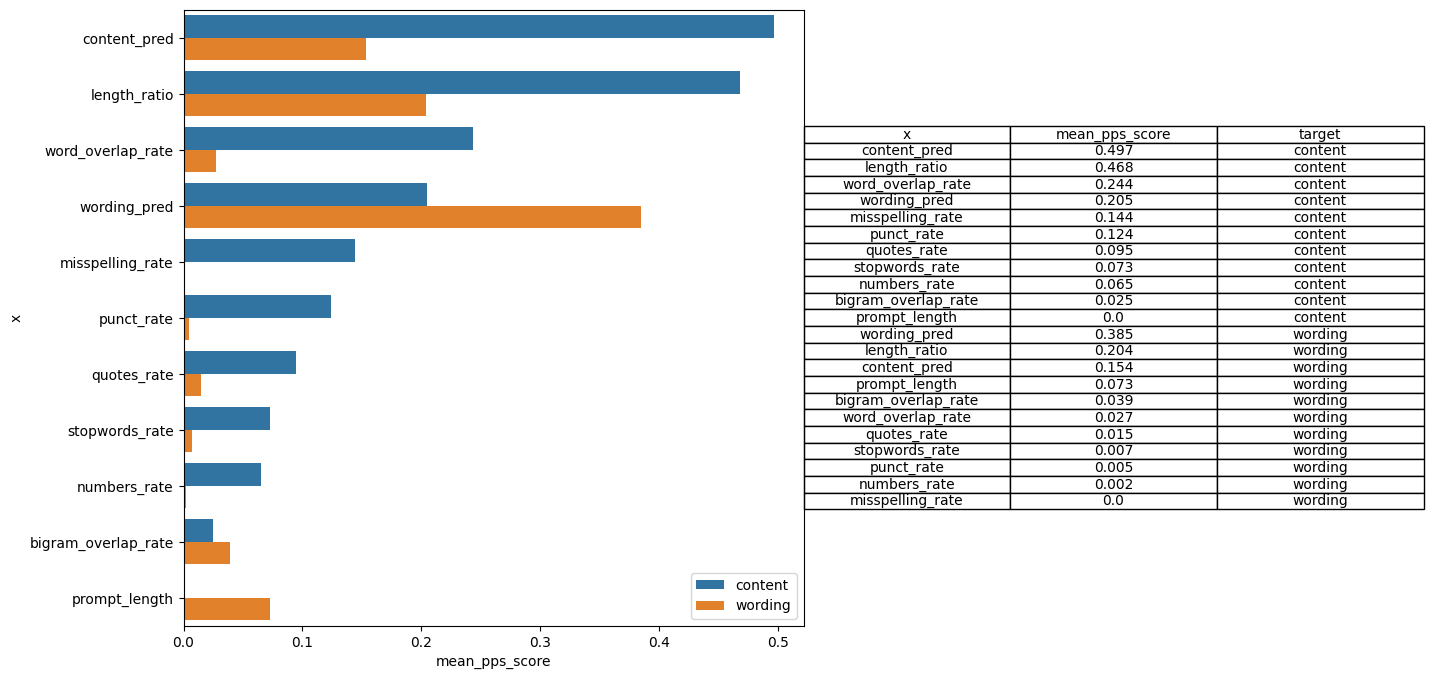

In [64]:
pps_predictors_cv = pd.DataFrame()
for target in targets:
  import matplotlib.pyplot as plt
  import seaborn as sns
  plt.figure(figsize=(8, 8))
  pps_target_predictors_cv  = get_target_mean_pps(target)
  pps_target_predictors_cv['target'] = target
  pps_predictors_cv = pd.concat([pps_predictors_cv, pps_target_predictors_cv] , axis = 0)
  pps_predictors_cv['mean_pps_score'] = pps_predictors_cv['mean_pps_score'].round(3)

columns = ["x", "mean_pps_score", "target"]
cell_text = []
ax = sns.barplot(data=pps_predictors_cv, y="x", x="mean_pps_score", hue = "target")
for i in range(len(pps_predictors_cv)):
    cell_text.append(pps_predictors_cv.iloc[i][columns].tolist())

ax.table(cellText=cell_text, colLabels=columns, cellLoc='center', loc='right')

plt.legend(loc='lower right')

In [65]:
def get_input_mean_pps(target = None):
  pps_score_df = pd.concat([df['ppscore'] for df in pps_input_scores], axis=1)
  mean_pps_score = pps_score_df.mean(axis=1)
  pps_matrix_cv = pps_input_scores[0][['x','y']].copy()
  pps_matrix_cv['mean_pps_score'] = mean_pps_score

  return pps_matrix_cv[['x', 'y', 'mean_pps_score']]

<Figure size 1000x1000 with 0 Axes>

<Axes: xlabel='x', ylabel='y'>

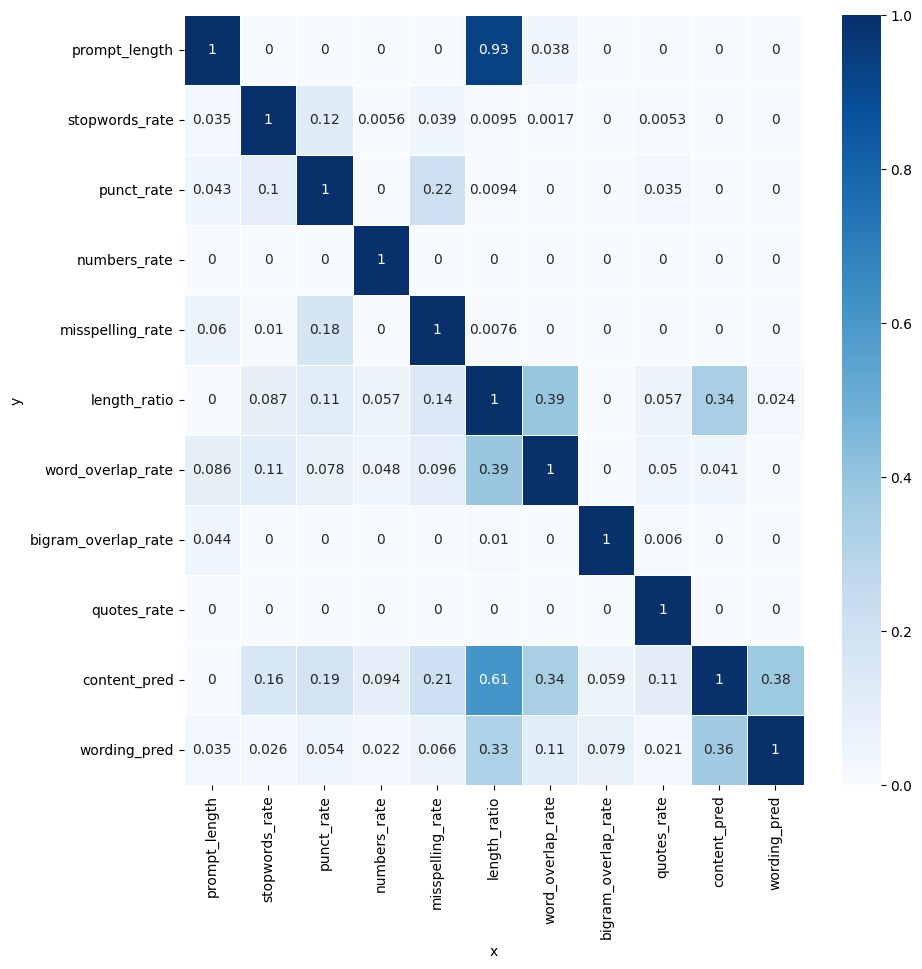

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 10))
pps_matrix_cv  = get_input_mean_pps(target)
pps_matrix_cv = pps_matrix_cv.pivot_table(columns='x', index='y', values='mean_pps_score', sort=False)
sns.heatmap(pps_matrix_cv, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True)

# Prediction

In [67]:
n_splits = Model_Config['n_splits']

drop_columns = [
                #"fold",
                "student_id", "prompt_id", "text",
                "prompt_question", "prompt_title",
                "prompt_text", "corrected_text" , "llm_gen_answer",
                "input", "title", "grade", "genre",
               ] + [
                f"content_pred_{i}" for i in range(n_splits)
                ] + [
                f"wording_pred_{i}" for i in range(n_splits)
                ]

In [68]:
pred_dict = {}
for target in targets:
    models = model_dict[target]
    preds = []

    for fold, model in enumerate(models):
        X_eval_cv = test.drop(columns=drop_columns, errors='ignore')

        pred = model.predict(X_eval_cv)
        preds.append(pred)

    pred_dict[target] = preds

In [69]:
for target in targets:
    preds = pred_dict[target]
    for i, pred in enumerate(preds):
        test[f"{target}_pred_{i}"] = pred

    test[target] = test[[f"{target}_pred_{fold}" for fold in range(n_splits)]].mean(axis=1)

In [70]:
submission_file = os.path.join(SYS_OUTPUT_DIR, "submission.csv")
test[["student_id", "content", "wording"]].to_csv(submission_file, index=False)